# HeteroGNN Models to Compute Heritage Values and Attributes

## Imports

In [1]:
import os
import os.path as osp
from itertools import product
from typing import Callable, List, Optional

import numpy as np
import scipy.sparse as sp

from torch_geometric.data import (
    HeteroData,
    InMemoryDataset,
    download_url,
    extract_zip,
)

In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import pandas as pd

import random

import torch
torch.manual_seed(1337)
torch.backends.cudnn.benchmark = True

from torch_geometric.transforms import RandomLinkSplit, ToUndirected
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, Linear, to_hetero
from torch_geometric.utils import to_undirected

import torch.nn.functional as F
from torch_geometric import seed_everything

from tqdm import tqdm
import torch.optim as optim
import pickle

In [3]:
from torch_geometric.nn import HeteroConv, Linear, SAGEConv

In [4]:
os.getcwd()

'D:\\surf\\TUD\\Paper\\Venice_Graph'

In [5]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [6]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print(device)

cuda:0


In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if cuda:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [8]:
args = Namespace(
    # Data and Path information
    path = 'dataset/Venice',
    save_dir='model_storage/HeteroGNN/',
    model_state_file='model.pth',
    
    # Model hyper parameters
    hidden_channels = 32,
    num_layers = 3,
    k=3,
    use_gdc=True,
    
    # Training hyper parameters
    sample_nodes = 25,
    batch_size=32,
    early_stopping_criteria=100,
    learning_rate=0.001,
    l2=2e-4,
    dropout_p=0,
    num_epochs=300,
    seed=42,
    
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

In [9]:
if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))

# handle dirs
handle_dirs(args.save_dir)    

Expanded filepaths: 
	model_storage/HeteroGNN/model.pth


## Constructing Dataset

In [10]:
class VEN(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [11]:
class VEN_XL(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['vis_only', 'vis_tex']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data.node_type = node_type_idx

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        for src, dst in product(node_types, node_types):
            for link in link_types:
                A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz'))[s[src]][:,s[dst]].tocoo()
                if A_sub.nnz>0:
                    row = torch.from_numpy(A_sub.row).to(torch.long)
                    col = torch.from_numpy(A_sub.col).to(torch.long)
                    data[src, f'{link}_link', dst].edge_index = torch.stack([row, col], dim=0)
                    data[src, f'{link}_link', dst].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)


        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [12]:
class VEN_links(InMemoryDataset):
    r"""A subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (1,190 nodes), nodes with both visual and textual
    features 'vis_tex' (1,761 nodes) and four types of links - social similarity
    'SOC' (488,103 links), spatial similarity (445,779 links), temporal similarity
    (501,191 links), and simple composed link (1,071,977 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 2,951
              - 1,071,977
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1sxcKiZr1YGDv06wr03nsk5HVZledgzi9'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['all']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        #data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        #data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        #data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        #data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data['all'].node_type = node_type_idx
        
        data['all'].att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data['all'].val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            #data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            #data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        #s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        #s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [10]:
class VEN_XL_Links(InMemoryDataset):
    r"""A large subset of Flickr post collected in Venice annotated with Heritage 
    Values and Attributes, as collected in the `"Heri-Graphs: A Workflow of 
    Creating Datasets for Multi-modal Machine Learning on Graphs of Heritage 
    Values and Attributes with Social Media" <https://arxiv.org/abs/2205.07545>`
    paper.
    VEN_XL is a heterogeneous graph containing two types of nodes - nodes with only 
    visual features 'vis_only' (31,140 nodes), nodes with both visual and textual
    features 'vis_tex' (49,823 nodes) and four types of links - social similarity
    'SOC' (76,422,265 links), spatial similarity (202,173,159 links), temporal similarity
    (71,135,671 links), and simple composed link (290,091,503 links).
    Vis_only nodes are represented with 982-dimensional visual features and are
    divided into 9 heritage attribute categories 
    ('architectural elements', 'form', 'gastronomy', 'interior',
    'landscape scenery and natural features', 'monuments', 'people', 'product', 
    'urban scenery').
    Vis_text nodes are represented with 1753-dimensional visual and textual 
    features and are divided into 9 heritage attribute categories plus 11 
    heritage value categories ('criterion i-x', 'other').
    Both types of nodes are also merged into a single type of node 'all' with 
    1753-dimensional features and 20-dimensional label categories.

    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            every access. (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.HeteroData` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
    
    Stats:
            * - #nodes
              - #edges
              - #features
              - #classes
            * - 80,963
              - 290,091,503
              - 1753
              - 20
    """

    url = 'https://drive.google.com/uc?export=download&id=1QZ5tyUWs6jYjh7mJrsnpou76iy-vb0CA'

    def __init__(self, root: str, transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None):
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self) -> List[str]:
        return [
            'A_simp.npz', 'A_SOC.npz', 'A_SPA.npz', 'A_TEM.npz', 'labels.npz',
            'node_types.npy', 'Textual_Features.npy', 'train_val_test_idx.npz',
            'Visual_Features.npy'
        ]

    @property
    def processed_file_names(self) -> str:
        return 'data.pt'

    def download(self):
        path = download_url(self.url, self.raw_dir)
        extract_zip(path, self.raw_dir)
        os.remove(path)

    def process(self):
        data = HeteroData()

        node_types = ['all']
        link_types = ['SOC', 'SPA', 'TEM', 'simp']

        vis = np.load(osp.join(self.raw_dir, 'Visual_Features.npy'),allow_pickle=True)[:,2:].astype(float)
        tex = np.load(osp.join(self.raw_dir, 'Textual_Features.npy'),allow_pickle=True)[:,5:].astype(float)

        x = np.hstack([vis,np.nan_to_num(tex)])


        node_type_idx = np.load(osp.join(self.raw_dir, 'node_types.npy'))
        node_type_idx = torch.from_numpy(node_type_idx).to(torch.long)

        #data['vis_only'].num_nodes = int((node_type_idx == 0).sum())
        #data['vis_tex'].num_nodes = int((node_type_idx == 1).sum())
        data['all'].num_nodes = len(node_type_idx)

        #data['vis_only'].x = torch.from_numpy(vis[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].x = torch.from_numpy(x[node_type_idx==1]).to(torch.float)
        data['all'].x = torch.from_numpy(x).to(torch.float)


        y_s = np.load(osp.join(self.raw_dir, 'labels.npz'), allow_pickle=True)
        att_lab = y_s['ATT_LAB'][:,1:10].astype(float)
        val_lab = np.nan_to_num(y_s['VAL_LAB'][:,2:13].astype(float))
        ys = np.hstack([att_lab, val_lab])

        #data['vis_only'].y = torch.from_numpy(att_lab[node_type_idx==0]).to(torch.float)
        #data['vis_tex'].y = torch.from_numpy(ys[node_type_idx==1]).to(torch.float)
        data['all'].y = torch.from_numpy(ys).to(torch.float)

        data['all'].node_type = node_type_idx
        
        data['all'].att_lab = torch.tensor(y_s['ATT_LAB'][:,-1].astype(bool))
        data['all'].val_lab = torch.tensor(y_s['VAL_LAB'][:,-1].astype(bool))

        split = np.load(osp.join(self.raw_dir, 'train_val_test_idx.npz'))
        for name in ['train', 'val', 'test']:
            idx = split[f'{name}_idx']
            idx = torch.from_numpy(idx).to(torch.long)
            mask = torch.zeros(data['all'].num_nodes, dtype=torch.bool)
            mask[idx] = True
            data['all'][f'{name}_mask'] = mask
            #data['vis_only'][f'{name}_mask'] = mask[node_type_idx==0]
            #data['vis_tex'][f'{name}_mask'] = mask[node_type_idx==1]

        
        s = {}
        #s['vis_only'] = np.arange(len(x))[node_type_idx==0]
        #s['vis_tex'] = np.arange(len(x))[node_type_idx==1]

        for link in link_types:
            A_sub = sp.load_npz(osp.join(self.raw_dir, f'A_{link}.npz')).tocoo()
            if A_sub.nnz>0:
                row = torch.from_numpy(A_sub.row).to(torch.long)
                col = torch.from_numpy(A_sub.col).to(torch.long)
                data['all', f'{link}_link', 'all'].edge_index = torch.stack([row, col], dim=0)
                data['all', f'{link}_link', 'all'].edge_attr = torch.from_numpy(A_sub.data).to(torch.long)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}()'

In [13]:
#path = osp.join(os.getcwd(), '../../data/VEN')
dataset = VEN_links('dataset/Venice_links')
data = dataset[0]

In [14]:
data['all'].n_id = torch.arange(data.num_nodes)
data = data.to(device)
data

HeteroData(
  all={
    num_nodes=2951,
    x=[2951, 1753],
    y=[2951, 20],
    node_type=[2951],
    att_lab=[2951],
    val_lab=[2951],
    train_mask=[2951],
    val_mask=[2951],
    test_mask=[2951],
    n_id=[2951]
  },
  (all, SOC_link, all)={
    edge_index=[2, 488103],
    edge_attr=[488103]
  },
  (all, SPA_link, all)={
    edge_index=[2, 445779],
    edge_attr=[445779]
  },
  (all, TEM_link, all)={
    edge_index=[2, 501191],
    edge_attr=[501191]
  },
  (all, simp_link, all)={
    edge_index=[2, 1071977],
    edge_attr=[1071977]
  }
)

In [13]:
data['all']['train_mask'].sum()

tensor(361, device='cuda:0')

## Data Loader for Sampling

In [15]:
from torch_geometric.loader import NeighborLoader

In [16]:
data.edge_types

[('all', 'SOC_link', 'all'),
 ('all', 'SPA_link', 'all'),
 ('all', 'TEM_link', 'all'),
 ('all', 'simp_link', 'all')]

In [27]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)

In [28]:
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)

In [29]:
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [30]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2948,
    x=[2948, 1753],
    y=[2948, 20],
    node_type=[2948],
    att_lab=[2948],
    val_lab=[2948],
    train_mask=[2948],
    val_mask=[2948],
    test_mask=[2948],
    n_id=[2948],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 26922],
    edge_attr=[26922]
  },
  (all, SPA_link, all)={
    edge_index=[2, 28515],
    edge_attr=[28515]
  },
  (all, TEM_link, all)={
    edge_index=[2, 27098],
    edge_attr=[27098]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [20]:
batch['all']['train_mask'].sum()

tensor(361, device='cuda:0')

## Helper Function

In [17]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_ATT_acc_val': 0,
            'early_stopping_best_VAL_acc_val': 0,
            'early_stopping_best_ATT_acc_val_2': 0,
            'early_stopping_lowest_loss': 1000,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_ATT_loss': [],
            'train_VAL_loss':[],
            'train_ATT_acc': [],
            'train_VAL_acc': [],
            'train_VAL_jac': [],
            'train_VAL_acc_1':[], 
            'val_loss': [],
            'val_ATT_loss': [],
            'val_VAL_loss':[],
            'val_ATT_acc': [],
            'val_VAL_acc': [],
            'val_VAL_jac': [],
            'val_VAL_acc_1': [],
            'test_loss': -1,
            'test_ATT_loss': -1,
            'test_VAL_loss':-1,
            'test_ATT_acc': -1,
            'test_VAL_acc': -1,
            'test_VAL_jac': -1,
            'test_VAL_acc_1': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        ATT_acc_tm1, ATT_acc_t = train_state['val_ATT_acc'][-2:]
        #ATT_acc_2_tm1, ATT_acc_2_t = train_state['val_ATT_acc_2'][-2:]
        VAL_acc_tm1, VAL_acc_t = train_state['val_VAL_acc'][-2:]
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If accuracy worsened
        #if loss_t >= train_state['early_stopping_lowest_loss']:
        #    train_state['early_stopping_step'] += 1
        
        if ATT_acc_t <= train_state['early_stopping_best_ATT_acc_val'] and VAL_acc_t <= train_state['early_stopping_best_VAL_acc_val']:# and ATT_acc_2_t <= train_state['early_stopping_best_ATT_acc_val_2']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model from sklearn
            if VAL_acc_t > train_state['early_stopping_best_VAL_acc_val']:
                train_state['early_stopping_best_VAL_acc_val'] = VAL_acc_t
                
            if ATT_acc_t > train_state['early_stopping_best_ATT_acc_val']:
                train_state['early_stopping_best_ATT_acc_val'] = ATT_acc_t
            
            #if ATT_acc_2_t > train_state['early_stopping_best_ATT_acc_val_2']:
            #    train_state['early_stopping_best_ATT_acc_val_2'] = ATT_acc_2_t
                
            if loss_t < train_state['early_stopping_lowest_loss']:
                train_state['early_stopping_lowest_loss'] = loss_t
                torch.save(model.state_dict(), train_state['model_filename'])
                
            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [18]:
def compute_cross_entropy(y_pred, y_target):
    y_target = y_target.cpu().float()
    y_pred = y_pred.cpu().float()
    criterion = nn.BCEWithLogitsLoss()
    return criterion(y_target, y_pred)

def compute_1_accuracy(y_pred, y_target):
    y_target_indices = y_target.max(dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target_indices).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_accuracy(y_pred, y_target, k=3):
    y_pred_indices = y_pred.topk(k, dim=1)[1]
    y_target_indices = y_target.max(dim=1)[1]
    n_correct = torch.tensor([y_pred_indices[i] in y_target_indices[i] for i in range(len(y_pred))]).sum().item()
    return n_correct / len(y_pred_indices) * 100

def compute_k_jaccard_index(y_pred, y_target, k=3):
    y_target_indices = y_target.topk(k, dim=1)[1]
    y_pred_indices = y_pred.max(dim=1)[1]
    jaccard = torch.tensor([len(np.intersect1d(y_target_indices[i], y_pred_indices[i]))/
                            len(np.union1d(y_target_indices[i], y_pred_indices[i]))
                            for i in range(len(y_pred))]).sum().item()
    return jaccard / len(y_pred_indices)

def compute_jaccard_index(y_pred, y_target, k=3, multilabel=False):
    
    threshold = 1.0/(k+1)
    threshold_2 = 0.5
    
    if multilabel:
        y_pred_indices = y_pred.gt(threshold_2)
    else:
        y_pred_indices = y_pred.gt(threshold)
    
    y_target_indices = y_target.gt(threshold)
        
    jaccard = ((y_target_indices*y_pred_indices).sum(axis=1)/((y_target_indices+y_pred_indices).sum(axis=1)+1e-8)).sum().item()
    return jaccard / len(y_pred_indices)

In [19]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

## Searched Best Hyper-Parameter

In [31]:
with open(args.save_dir+'42/hyperdict.p', 'rb') as fp:
    hyperdict= pickle.load(fp)

In [32]:
len(hyperdict)

45

In [33]:
hyper_df = pd.DataFrame(hyperdict).T

In [34]:
hyper_df[(hyper_df.early_stopping_best_VAL_acc_val + hyper_df.early_stopping_best_VAL_acc_val)>196]

stop_early early_stopping_step early_stopping_best_ATT_acc_val  \
0 2 32 0.0100       True                 100                       86.043165   
    64 0.0001       True                 100                       89.640288   
  3 32 0.0010       True                 100                       89.352518   
       0.0001      False                  45                       87.769784   
  5 32 0.0001      False                   3                       87.769784   

              early_stopping_best_VAL_acc_val  \
0 2 32 0.0100                        98.53499   
    64 0.0001                       98.116416   
  3 32 0.0010                       98.744277   
       0.0001                       98.744277   
  5 32 0.0001                        98.53499   

              early_stopping_best_ATT_acc_val_2 early_stopping_lowest_loss  \
0 2 32 0.0100                                 0                   4.307965   
    64 0.0001                                 0                   4.212483   
  3 32 0.0010                                 0                   4.226059   
       0.0001                                 0                   4.215985   
  5 32 0.0001                                 0                   4.230353   

              learning_rate epoch_index  \
0 2 32 0.0100          0.01         150   
    64 0.0001        0.0001         271   
  3 32 0.0010         0.001         157   
       0.0001        0.0001         299   
  5 32 0.0001        0.0001         299   

                                                      train_loss  \
0 2 32 0.0100  [5.701295952002208, 3.371192216873169, 2.93144...   
    64 0.0001  [4.122023801008861, 3.6332812507947287, 3.4577...   
  3 32 0.0010  [3.9881125489870706, 3.4168097178141275, 3.183...   
       0.0001  [4.394130706787109, 4.11641263961792, 3.931373...   
  5 32 0.0001  [4.4204078912734985, 4.052810370922089, 3.7973...   

                                                  train_ATT_loss  ...  \
0 2 32 0.0100  [1.8001848581425042, 1.278290778315959, 0.9924...  ...   
    64 0.0001  [1.8689053507722977, 1.7542523825928116, 1.637...  ...   
  3 32 0.0010  [1.7477501148662409, 1.5433839830335156, 1.320...  ...   
       0.0001  [2.019101794076428, 1.9337231571324314, 1.8795...  ...   
  5 32 0.0001  [2.0110542879870725, 1.9153890008741468, 1.861...  ...   

                                                     val_VAL_jac  \
0 2 32 0.0100  [0.20119904201483452, 0.2581687443901413, 0.28...   
    64 0.0001  [0.030630041421408325, 0.19073468597724808, 0....   
  3 32 0.0010  [0.19956834549006744, 0.2770612624945764, 0.26...   
       0.0001  [0.0, 0.011510791366906475, 0.0680183126226291...   
  5 32 0.0001  [0.0, 0.058940483976455196, 0.1642816659092824...   

                                                   val_VAL_acc_1 test_loss  \
0 2 32 0.0100  [26.183562241116203, 38.57684761281884, 48.260...        -1   
    64 0.0001  [24.10202746893394, 31.659036407237853, 40.239...        -1   
  3 32 0.0010  [46.34314366688468, 54.34139960758666, 49.0752...        -1   
       0.0001  [15.289295836058425, 18.41726618705036, 21.160...        -1   
  5 32 0.0001  [58.74776542402442, 64.80575539568345, 67.7357...        -1   

              test_ATT_loss test_VAL_loss test_ATT_acc test_VAL_acc  \
0 2 32 0.0100            -1            -1           -1           -1   
    64 0.0001            -1            -1           -1           -1   
  3 32 0.0010            -1            -1           -1           -1   
       0.0001            -1            -1           -1           -1   
  5 32 0.0001            -1            -1           -1           -1   

              test_VAL_jac test_VAL_acc_1                     model_filename  
0 2 32 0.0100           -1             -1  model_storage/HeteroGNN/model.pth  
    64 0.0001           -1             -1  model_storage/HeteroGNN/model.pth  
  3 32 0.0010           -1             -1  model_storage/HeteroGNN/model.pth  
       0.0001           -1             -1

In [39]:
hyper_df[(hyper_df.early_stopping_lowest_loss<4.2)]

stop_early early_stopping_step early_stopping_best_ATT_acc_val  \
0 2 128 0.0001       True                 100                       89.352518   
    256 0.0001      False                   9                       90.503597   
  3 128 0.0010      False                  25                       90.503597   
        0.0001      False                  50                       89.208633   
    256 0.0010      False                   9                       90.215827   
  5 128 0.0001      False                  43                       89.208633   

               early_stopping_best_VAL_acc_val  \
0 2 128 0.0001                       77.549597   
    256 0.0001                       94.977109   
  3 128 0.0010                        92.24504   
        0.0001                       90.977981   
    256 0.0010                       94.977109   
  5 128 0.0001                       88.036625   

               early_stopping_best_ATT_acc_val_2 early_stopping_lowest_loss  \
0 2 128 0.0001                                 0                   4.195606   
    256 0.0001                                 0                   4.190596   
  3 128 0.0010                                 0                   4.195897   
        0.0001                                 0                   4.196027   
    256 0.0010                                 0                   4.197124   
  5 128 0.0001                                 0                   4.192393   

               learning_rate epoch_index  \
0 2 128 0.0001        0.0001         292   
    256 0.0001        0.0001         299   
  3 128 0.0010         0.001         299   
        0.0001        0.0001         299   
    256 0.0010         0.001         299   
  5 128 0.0001        0.0001         299   

                                                       train_loss  \
0 2 128 0.0001  [4.032147785027822, 3.5648412505785623, 3.3649...   
    256 0.0001  [3.8349266250928244, 3.401456912358602, 3.1584...   
  3 128 0.0010  [3.9379881024360657, 3.30867866675059, 3.00129...   
        0.0001  [4.013673742612203, 3.5879997611045837, 3.4103...   
    256 0.0010  [4.122933804988861, 3.1471897959709167, 2.8036...   
  5 128 0.0001  [4.073585728804271, 3.665245294570923, 3.53939...   

                                                   train_ATT_loss  ...  \
0 2 128 0.0001  [1.8548441715848083, 1.70860315888212, 1.54358...  ...   
    256 0.0001  [1.7400510050253195, 1.5369147234015847, 1.349...  ...   
  3 128 0.0010  [1.7698697393290554, 1.376316657026719, 1.1517...  ...   
        0.0001  [1.8652556794502069, 1.731206324952461, 1.5743...  ...   
    256 0.0010  [1.6379114300260254, 1.2345053076413859, 0.989...  ...   
  5 128 0.0001  [1.8968283849409742, 1.810092810448517, 1.7256...  ...   

                                                      val_VAL_jac  \
0 2 128 0.0001  [0.18747329442465202, 0.24502725225714314, 0.3...   
    256 0.0001  [0.2583765721534212, 0.33895211571360145, 0.33...   
  3 128 0.0010  [0.2788431093462521, 0.33746239571730396, 0.31...   
        0.0001  [0.08609112709832133, 0.24117142825961396, 0.2...   
    256 0.0010  [0.3065126117725427, 0.3338609126015949, 0.364...   
  5 128 0.0001  [0.11103553520819706, 0.19264879039151486, 0.2...   

                                                    val_VAL_acc_1 test_loss  \
0 2 128 0.0001  [39.44800523217789, 45.29670808807499, 39.2047...        -1   
    256 0.0001  [60.17876607804667, 55.57444953128406, 41.0882...        -1   
  3 128 0.0010  [38.61085676913015, 41.297580117724, 35.844778...        -1   
        0.0001  [59.15500327011116, 40.27381730978855, 39.2047...        -1   
    256 0.0010  [36.68192718552431, 41.9141050795727, 43.40178...        -1   
  5 128 0.0001  [13.614998909962935, 30.182690211467193, 35.23...        -1   

               test_ATT_loss test_VAL_loss test_ATT_acc test_VAL_acc  \
0 2 128 0.0001            -1            -1           -1           -1   
    256 0.0001            -1            -1      

## Re-run Model and get Inference Data

In [20]:
class HeteroGNN_L(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers, in_channels=None):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1] if 'all' in edge_type and not 'simp_link' in edge_type
            })
            self.convs.append(conv)

        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(2*hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_0 = self.lin1(x_dict['all']).relu()
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        x = self.lin2(torch.hstack([x_0,x_dict['all']]))
        return x

In [44]:
@torch.no_grad()
def init_params(model, train_loader):
    # Initialize lazy parameters via forwarding a single batch to the model:
    batch = next(iter(train_loader))
    batch = batch.to(device)
    batch = batch.to(device, 'edge_index')
    out = model(batch.x_dict, batch.edge_index_dict)

def train(model, optimizer, train_loader):
    model.train()

    total_examples = total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device)
        batch_size = args.batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict
        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        y = batch.y_dict['all']
        y_att = y[:,:9]
        y_val = y[:,9:]
        
        loss = F.cross_entropy(out_att, y_att[:batch_size]) + F.cross_entropy(out_val, y_val[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

@torch.no_grad()
def test(model, loader, mode='train'):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    running_1_val = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict

        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch['all'].att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch['all'].val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y_dict['all']
        y_att = y[:,:9]
        y_val = y[:,9:]

        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]

    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [38]:
def initialization():
    set_seed_everywhere(args.seed, args.cuda)
    #transform = T.Compose([T.ToSparseTensor()])
    dataset = VEN_links('dataset/Venice_links')
    data = dataset[0].to(device)
    
    train_loader = NeighborLoader(
        data,
        # Sample 30 neighbors for each node and edge type for 2 iterations
        num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
        # Use a batch size of 128 for sampling training nodes of type paper
        batch_size=args.batch_size,
        input_nodes=('all', data['all'].train_mask),
    )
    val_loader = NeighborLoader(
        data,
        # Sample 30 neighbors for each node and edge type for 2 iterations
        num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
        # Use a batch size of 128 for sampling training nodes of type paper
        batch_size=args.batch_size,
        input_nodes=('all', data['all'].val_mask),
    )
    test_loader = NeighborLoader(
        data,
        # Sample 30 neighbors for each node and edge type for 2 iterations
        num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
        # Use a batch size of 128 for sampling training nodes of type paper
        batch_size=args.batch_size,
        input_nodes=('all', data['all'].test_mask),
    )
 
    model = HeteroGNN_L(data.metadata(), hidden_channels=32, out_channels=data.y_dict['all'].shape[-1],
                  num_layers=3, in_channels = data.x_dict['all'].shape[-1]).to(device)
    return data, model, train_loader, val_loader, test_loader


In [18]:
def training_loop(verbose=False):
    
    _, model, train_loader, val_loader, test_loader = initialization()
    if torch.cuda.device_count() > 1:
        print("Use {} GPUs !".format(torch.cuda.device_count()))
        model = DataParallel(model)
    
    init_params(model, train_loader)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=args.l2)
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    #                                           mode='min', factor=0.5,
    #                                           patience=1)

    train_state = make_train_state(args)

    try:
        for epoch in range(args.num_epochs):
            train_state['epoch_index'] = epoch
            
            loss = train(model, optimizer, train_loader)
            train_loss_att, train_loss_val, train_att_acc, train_val_acc, train_val_jac, train_val_1 = test(model, train_loader)
            val_loss_att, val_loss_val, val_att_acc, val_val_acc, val_val_jac, val_val_1 = test(model, val_loader)
            if verbose:
                print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train_ATT: {train_att_acc:.4f}, Train_VAL: {train_val_acc:.4f}, Val_vis_tex_ATT: {val_att_acc:.4f}, Val_vis_tex_VAL: {val_val_acc:.4f}')
            
            train_state['train_loss'].append(loss)
            train_state['train_ATT_loss'].append(train_loss_att)
            train_state['train_VAL_loss'].append(train_loss_val)
            train_state['train_ATT_acc'].append(train_att_acc)
            train_state['train_VAL_acc'].append(train_val_acc)
            train_state['train_VAL_jac'].append(train_val_jac)
            train_state['train_VAL_acc_1'].append(train_val_1)
            
            train_state['val_ATT_loss'].append(val_loss_att)
            train_state['val_VAL_loss'].append(val_loss_val)
            train_state['val_loss'].append(val_loss_att + 3*val_loss_val)
            train_state['val_ATT_acc'].append(val_att_acc)
            train_state['val_VAL_acc'].append(val_val_acc)
            train_state['val_VAL_jac'].append(val_val_jac)
            train_state['val_VAL_acc_1'].append(val_val_1)
            
            train_state = update_train_state(args=args, model=model,
                                                train_state=train_state)
            if train_state['stop_early']:
                break

    except KeyboardInterrupt:
        print("Exiting loop")
        pass
    
    return train_state

In [ ]:
train_state = training_loop(verbose=True)

In [39]:
model = HeteroGNN_L(data.metadata(), hidden_channels=32, out_channels=data.y_dict['all'].shape[-1],
                  num_layers = 3, in_channels = data.x_dict['all'].shape[-1]).to(device)

In [40]:
model.load_state_dict(torch.load(args.save_dir+'Hetero_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [41]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [36]:
set_seed_everywhere(args.seed, args.cuda)
test_loss_att, test_loss_val, test_att_acc, test_val_acc, test_val_jac, test_val_1 = test(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.13it/s]


In [45]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.26it/s]


(0.7261433411503102,
 1.6014879826363435,
 100.0,
 100.0,
 0.8550323211585386,
 88.08864265927978)

In [46]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.12it/s]


(0.8145147678328724,
 1.620982464898396,
 96.54471544715447,
 99.50738916256158,
 0.7651888443331413,
 84.72906403940887)

In [47]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 25.48it/s]


(0.8253275398942632,
 1.6446616904189189,
 95.62624254473161,
 99.47916666666667,
 0.7118055646618208,
 77.08333333333333)

In [40]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 30.84it/s]


In [41]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [42]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.814461,1.621137,96.626016,99.113300,0.773317,84.729064
std,0.000261,0.000234,0.257096,0.207703,0.006294,1.206645
min,0.814182,1.620698,96.138211,99.014778,0.765189,82.758621
25%,0.814262,1.621013,96.544715,99.014778,0.768473,83.866995
50%,0.814409,1.621122,96.646341,99.014778,0.771757,84.975369
75%,0.814638,1.621296,96.747967,99.014778,0.776683,85.591133
max,0.814974,1.621454,96.951220,99.507389,0.783251,86.206897


In [43]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.826263,1.644597,95.646123,99.114583,0.717361,77.864583
std,0.000505,0.000228,0.317124,0.351536,0.004430,0.368285
min,0.825291,1.644249,95.228628,98.437500,0.710069,77.083333
25%,0.826116,1.644440,95.427435,98.958333,0.714410,77.604167
50%,0.826271,1.644601,95.626243,98.958333,0.717448,78.125000
75%,0.826411,1.644749,95.974155,99.479167,0.720052,78.125000
max,0.827022,1.644931,96.023857,99.479167,0.724826,78.125000


In [44]:
val_df.to_csv(args.save_dir + 'val_metrics.csv', sep='\t')
test_df.to_csv(args.save_dir + 'test_metrics.csv', sep='\t')

In [45]:
train_state['test_ATT_loss']=test_loss_att
train_state['test_VAL_loss']=test_loss_val
train_state['test_loss']=test_loss_att + 3*test_loss_val
train_state['test_ATT_acc']=test_att_acc
train_state['test_VAL_acc_1']=test_val_1
train_state['test_VAL_acc']=test_val_acc
train_state['test_VAL_jac']=test_val_jac

In [46]:
train_state

{'stop_early': False,
 'early_stopping_step': 36,
 'early_stopping_best_ATT_acc_val': 97.15447154471545,
 'early_stopping_best_VAL_acc_val': 100.0,
 'early_stopping_best_ATT_acc_val_2': 0,
 'early_stopping_lowest_loss': 5.6760863951857985,
 'learning_rate': 0.001,
 'epoch_index': 299,
 'train_loss': [4.388954063256581,
  4.111910243829091,
  3.9167340795199075,
  3.7769437630971274,
  3.663265665372213,
  3.571526805559794,
  3.4576874375343323,
  3.3690043489138284,
  3.297426422437032,
  3.2279419898986816,
  3.1783733566602073,
  3.0797815521558127,
  3.0304313699404397,
  2.984511991341909,
  2.927460332711538,
  2.8726566433906555,
  2.8256458242734275,
  2.8014265497525535,
  2.747178097565969,
  2.724012811978658,
  2.7161844968795776,
  2.6957101424535117,
  2.6611533761024475,
  2.654522637526194,
  2.6134462555249534,
  2.6218040386835733,
  2.591593027114868,
  2.602132042249044,
  2.571110506852468,
  2.5524837970733643,
  2.551305890083313,
  2.52798322836558,
  2.53585275

In [47]:
with open(args.save_dir+'Hetero_best_model/best_config.p', 'wb') as fp:
    pickle.dump(train_state,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
with open(args.save_dir+'Hetero_best_model/best_config.p', 'rb') as fp:
    train_state = pickle.load(fp)

In [49]:
states = pd.DataFrame(train_state['val_VAL_acc'], columns=['val_VAL'])
states['train_VAL'] = pd.DataFrame(train_state['train_VAL_acc'])
states['val_ATT'] = pd.DataFrame(train_state['val_ATT_acc'])
states['train_ATT'] = pd.DataFrame(train_state['train_ATT_acc'])
states['val_VAL_1'] = pd.DataFrame(train_state['val_VAL_acc_1'])
states['train_VAL_1'] = pd.DataFrame(train_state['train_VAL_acc_1'])
states['train_VAL_jac'] = pd.DataFrame(train_state['train_VAL_jac'])
states['val_VAL_jac'] = pd.DataFrame(train_state['val_VAL_jac'])

In [50]:
states

,val_VAL,train_VAL,val_ATT,train_ATT,val_VAL_1,train_VAL_1,train_VAL_jac,val_VAL_jac
0,76.354680,74.515235,12.804878,20.498615,30.049261,32.409972,0.005540,0.000000
1,78.817734,77.562327,13.414634,21.329640,33.990148,34.903047,0.058172,0.044335
2,76.847291,77.008310,20.121951,30.470914,37.438424,33.518006,0.139428,0.142857
3,79.310345,79.501385,29.471545,43.213296,36.453202,40.166205,0.183749,0.152709
4,86.699507,86.149584,35.975610,49.861496,48.275862,50.692521,0.236380,0.239737
...,...,...,...,...,...,...,...,...
295,99.014778,99.722992,96.138211,100.000000,80.295567,88.365651,0.844414,0.739737
296,98.522167,100.000000,96.341463,100.000000,79.802956,89.196676,0.830102,0.711002
297,98.029557,99.722992,95.934959,100.000000,75.862069,87.534626,0.827793,0.717570
298,98.522167,99.445983,95.731707,100.000000,78.325123,89.196676,0.844875,0.728243


In [51]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

<AxesSubplot:>

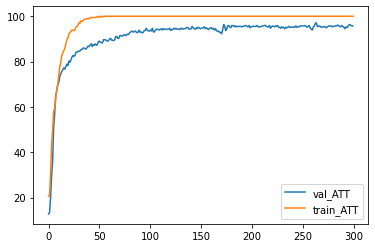

In [52]:
states[['val_ATT','train_ATT']].plot()

<AxesSubplot:>

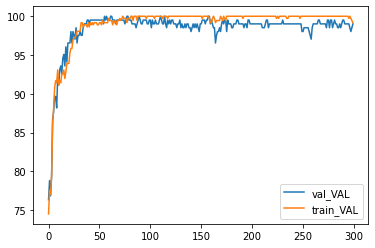

In [53]:
states[['val_VAL','train_VAL']].plot()

<AxesSubplot:>

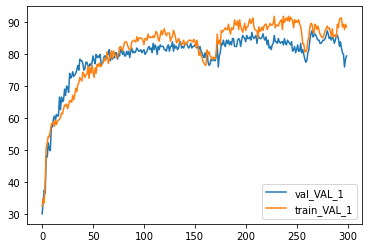

In [54]:
states[['val_VAL_1','train_VAL_1']].plot()

<AxesSubplot:>

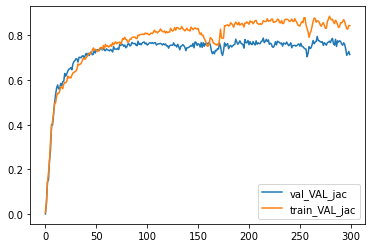

In [55]:
states[['val_VAL_jac','train_VAL_jac']].plot()

In [56]:
unlabel_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', ~(data['all'].train_mask + data['all'].val_mask + data['all'].test_mask)),
)

In [57]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict
        
        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch['all'].n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [58]:
pred_train = predict(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 27.32it/s]


In [59]:
pred_val = predict(model, val_loader)
pred_test = predict(model, test_loader)
pred_unlab = predict(model, unlabel_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 48.49it/s]


In [60]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [61]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [62]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [63]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.016423,0.050291,0.012526,0.008743,0.110640,0.087991,0.036223,0.004730,0.672433,0.083771,0.332159,0.204477,0.234954,0.016103,0.101231,0.005806,0.003253,0.003801,0.003791,0.010653
1.0,0.007282,0.021287,0.007297,0.004733,0.031022,0.035716,0.010356,0.002186,0.880121,0.145999,0.416139,0.177033,0.117582,0.012862,0.094682,0.006688,0.004986,0.004848,0.005506,0.013674
2.0,0.039838,0.067240,0.025460,0.021443,0.145253,0.285262,0.100707,0.012931,0.301865,0.157047,0.288716,0.207685,0.171816,0.009803,0.137863,0.005051,0.003682,0.003071,0.003312,0.011954
3.0,0.044647,0.171641,0.054057,0.013017,0.012908,0.070298,0.576590,0.045380,0.011461,0.062484,0.026733,0.193096,0.063548,0.018841,0.590197,0.011869,0.009724,0.005058,0.009313,0.009137
4.0,0.240394,0.270734,0.008813,0.069668,0.012651,0.328453,0.045598,0.011963,0.011726,0.205327,0.084273,0.090498,0.212623,0.010540,0.375556,0.004466,0.003712,0.002396,0.002357,0.008251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.012299,0.352459,0.196328,0.019530,0.004680,0.019436,0.325722,0.056517,0.013029,0.307784,0.166586,0.258492,0.167580,0.022277,0.036914,0.007928,0.004127,0.003969,0.011200,0.013142
2947.0,0.001303,0.015353,0.350792,0.007368,0.001894,0.001741,0.567814,0.051717,0.002019,0.302574,0.133512,0.271232,0.188981,0.020561,0.044853,0.006896,0.004195,0.004115,0.010768,0.012314
2948.0,0.037760,0.610750,0.054277,0.017287,0.019161,0.025083,0.187835,0.035659,0.012188,0.213285,0.251156,0.273004,0.172218,0.019935,0.030302,0.005923,0.004361,0.004487,0.013026,0.012303


In [64]:
preds_df.to_csv(args.save_dir + 'preds.csv', sep='\t')

In [65]:
states.to_csv(args.save_dir + 'train_state.csv', sep='\t')

## Per-Class Metrics

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
preds = pd.read_csv(args.save_dir + 'preds.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.016423,0.050291,0.012526,0.008743,0.110640,0.087991,0.036223,0.004730,0.672433,0.083771,0.332159,0.204477,0.234954,0.016103,0.101231,0.005806,0.003253,0.003801,0.003791,0.010653
1.0,0.007282,0.021287,0.007297,0.004733,0.031022,0.035716,0.010356,0.002186,0.880121,0.145999,0.416139,0.177033,0.117582,0.012862,0.094682,0.006688,0.004986,0.004848,0.005506,0.013674
2.0,0.039838,0.067240,0.025460,0.021443,0.145254,0.285262,0.100707,0.012931,0.301865,0.157047,0.288716,0.207685,0.171816,0.009803,0.137863,0.005051,0.003682,0.003071,0.003312,0.011954
3.0,0.044647,0.171641,0.054057,0.013017,0.012908,0.070298,0.576590,0.045380,0.011461,0.062484,0.026733,0.193096,0.063548,0.018841,0.590197,0.011869,0.009724,0.005058,0.009313,0.009137
4.0,0.240394,0.270734,0.008813,0.069668,0.012651,0.328453,0.045598,0.011963,0.011726,0.205327,0.084273,0.090498,0.212623,0.010540,0.375556,0.004466,0.003712,0.002396,0.002357,0.008251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946.0,0.012299,0.352459,0.196328,0.019530,0.004680,0.019436,0.325722,0.056517,0.013029,0.307784,0.166586,0.258492,0.167580,0.022277,0.036914,0.007928,0.004127,0.003969,0.011200,0.013142
2947.0,0.001303,0.015353,0.350792,0.007368,0.001894,0.001741,0.567814,0.051717,0.002019,0.302574,0.133512,0.271232,0.188981,0.020561,0.044853,0.006896,0.004195,0.004115,0.010768,0.012314
2948.0,0.037760,0.610750,0.054277,0.017287,0.019161,0.025083,0.187835,0.035659,0.012188,0.213285,0.251156,0.273004,0.172218,0.019935,0.030302,0.005923,0.004361,0.004487,0.013026,0.012303


In [68]:
pred = torch.tensor(np.array(preds)).to(device)

In [69]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [73]:
test_ATT_conf = confusion_matrix(data['all'].y[(data['all'].att_lab) * data['all'].test_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data['all'].att_lab) * data['all'].test_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
test_VAL_conf = confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].test_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data['all'].val_lab) * data['all'].test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].test_mask][:,9:].cpu(),  
                                 pred[(data['all'].val_lab) * data['all'].test_mask][:,9:].cpu(),3)).astype(int)

In [74]:
test_ATT_conf

array([[ 63,   0,   0,   0,   0,   1,   0,   0,   0],
       [  1, 141,   0,   0,   0,   1,   2,   0,   0],
       [  0,   0,  11,   0,   0,   0,   0,   0,   0],
       [  2,   0,   0,  14,   0,   2,   0,   0,   0],
       [  0,   0,   0,   0,  71,   0,   1,   0,   0],
       [  0,   3,   0,   0,   0,  99,   0,   0,   0],
       [  0,   4,   0,   0,   2,   0,  71,   0,   0],
       [  0,   0,   1,   0,   0,   0,   1,   0,   0],
       [  1,   1,   0,   0,   0,   0,   0,   0,  10]], dtype=int64)

In [75]:
test_VAL_conf

array([[51,  2,  4,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2, 19,  1,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  5, 22,  3,  0,  3,  0,  0,  0,  0,  0],
       [ 1,  3,  2, 26,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  3,  1,  5,  0, 30,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [76]:
test_VAL_conf_k

array([[ 91,  54,  54,  43,   0,  40,   0,   0,   0,   0,   0],
       [ 52,  90,  75,  64,   0,  28,   0,   0,   0,   0,   0],
       [ 59,  83, 117,  90,   0,  59,   0,   0,   0,   0,   0],
       [ 58,  78,  94, 117,   0,  52,   0,   0,   0,   0,   0],
       [  0,   3,   3,   3,   0,   0,   0,   0,   0,   0,   0],
       [ 48,  37,  73,  73,   0,  78,   0,   0,   0,   0,   0],
       [  1,   0,   2,   0,   0,   2,   0,   0,   0,   1,   0],
       [  0,   0,   1,   0,   0,   1,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   1,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [77]:
val_ATT_conf = confusion_matrix(data['all'].y[(data['all'].att_lab) * data['all'].val_mask][:,:9].argmax(axis=1).cpu(), 
                                 pred[(data['all'].att_lab) * data['all'].val_mask][:,:9].argmax(axis=1).cpu(), labels = range(9))
val_VAL_conf = confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].val_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[(data['all'].val_lab) * data['all'].val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data['all'].y[(data['all'].val_lab) * data['all'].val_mask][:,9:].cpu(),  
                                 pred[(data['all'].val_lab) * data['all'].val_mask][:,9:].cpu(),3)).astype(int)

In [78]:
val_ATT_conf

array([[ 61,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 144,   0,   0,   0,   1,   1,   0,   0],
       [  0,   0,   8,   0,   0,   0,   0,   0,   0],
       [  1,   1,   0,  20,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,  74,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0, 102,   0,   0,   0],
       [  0,   1,   1,   0,   0,   0,  60,   0,   0],
       [  0,   0,   1,   0,   0,   0,   4,   0,   0],
       [  0,   1,   0,   0,   2,   0,   0,   0,   7]], dtype=int64)

In [79]:
val_VAL_conf

array([[66,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 17,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 26,  2,  0,  2,  0,  0,  0,  0,  0],
       [ 1,  1,  0, 31,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5,  4,  4,  1,  0, 36,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

In [80]:
val_VAL_conf_k

array([[104,  63,  54,  60,   0,  43,   0,   0,   0,   0,   0],
       [ 62,  91,  61,  70,   1,  36,   0,   0,   0,   0,   0],
       [ 59,  58, 114,  91,   0,  71,   0,   0,   0,   0,   0],
       [ 70,  80,  99, 120,   1,  56,   0,   0,   0,   0,   0],
       [  0,   8,   7,   8,   1,   0,   0,   0,   0,   0,   0],
       [ 53,  42,  88,  68,   0,  88,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [81]:
pd.concat([pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT.csv')
pd.concat([pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL.csv')
pd.concat([pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k.csv')

In [82]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [83]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [84]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [85]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [86]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [87]:
metrics_df.to_csv(args.save_dir+'per_class_metrics.csv')

## TEM links

In [90]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [91]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=1840,
    x=[1840, 1753],
    y=[1840, 20],
    node_type=[1840],
    att_lab=[1840],
    val_lab=[1840],
    train_mask=[1840],
    val_mask=[1840],
    test_mask=[1840],
    n_id=[1840],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, SPA_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, TEM_link, all)={
    edge_index=[2, 40865],
    edge_attr=[40865]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [92]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [93]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.91it/s]


(1.1346464411373614,
 1.791048172108024,
 83.10249307479225,
 93.35180055401662,
 0.5415512623879388,
 54.016620498614955)

In [94]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 39.11it/s]


(1.2173465841669378,
 1.7932460578204377,
 84.34959349593495,
 88.66995073891626,
 0.5566502557012248,
 53.69458128078818)

In [95]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 37.68it/s]


(1.2452885824927753,
 1.8158961217850447,
 80.9145129224652,
 87.5,
 0.5212673656642437,
 56.25)

In [96]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 68.55it/s]


In [97]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [98]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,1.216514,1.793131,84.390244,8.866995e+01,0.553038,54.039409
std,0.000174,0.000216,0.299945,1.497956e-14,0.002514,0.616584
min,1.216272,1.792778,83.739837,8.866995e+01,0.549261,53.201970
25%,1.216383,1.792933,84.349593,8.866995e+01,0.551724,53.694581
50%,1.216483,1.793219,84.349593,8.866995e+01,0.553777,53.694581
75%,1.216677,1.793257,84.502033,8.866995e+01,0.554187,54.556650
max,1.216766,1.793409,84.959350,8.866995e+01,0.556650,55.172414


In [99]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.244264,1.816401,81.312127,87.708333,0.521224,56.145833
std,0.000207,0.000193,0.209561,0.439205,0.002831,0.219603
min,1.243927,1.815987,81.113320,86.979167,0.517361,55.729167
25%,1.244172,1.816305,81.113320,87.500000,0.518989,56.250000
50%,1.244201,1.816427,81.312127,88.020833,0.520399,56.250000
75%,1.244376,1.816547,81.461233,88.020833,0.524197,56.250000
max,1.244604,1.816600,81.709742,88.020833,0.524740,56.250000


In [100]:
val_df.to_csv(args.save_dir + 'TEM_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'TEM_test_metrics_transfer.csv', sep='\t')

## SPA links

In [101]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [102]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2702,
    x=[2702, 1753],
    y=[2702, 20],
    node_type=[2702],
    att_lab=[2702],
    val_lab=[2702],
    train_mask=[2702],
    val_mask=[2702],
    test_mask=[2702],
    n_id=[2702],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, SPA_link, all)={
    edge_index=[2, 64239],
    edge_attr=[64239]
  },
  (all, TEM_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [103]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.27it/s]


(1.2329906126138577,
 1.7856713189973066,
 72.57617728531856,
 88.36565096952909,
 0.4893813569129669,
 47.64542936288089)

In [104]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 28.85it/s]


(1.4011133589395663,
 1.7888418289240946,
 64.02439024390245,
 81.77339901477832,
 0.46469622644884834,
 45.320197044334975)

In [105]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 27.67it/s]


(1.4115610653553048,
 1.817808320124944,
 63.02186878727634,
 86.45833333333333,
 0.4440104228754838,
 51.041666666666664)

In [106]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader,'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader,'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 38.99it/s]


In [107]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [108]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.401637,1.788999,64.126016,82.019704,0.469951,45.369458
std,0.000578,0.000306,0.239535,0.348328,0.004365,0.279629
min,1.400590,1.788591,63.821138,81.773399,0.465517,44.827586
25%,1.401324,1.788725,63.871951,81.773399,0.466338,45.320197
50%,1.401658,1.789015,64.227642,81.773399,0.469622,45.320197
75%,1.401967,1.789168,64.227642,82.266010,0.472701,45.320197
max,1.402671,1.789471,64.430894,82.758621,0.477833,45.812808


In [109]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,1.000000e+01,10.000000,10.000000
mean,1.410991,1.817671,63.121272,8.645833e+01,0.449826,51.510417
std,0.000676,0.000258,0.285034,1.497956e-14,0.004312,0.573180
min,1.410006,1.817257,62.624254,8.645833e+01,0.442274,50.520833
25%,1.410490,1.817515,63.021869,8.645833e+01,0.447483,51.041667
50%,1.411199,1.817665,63.121272,8.645833e+01,0.449653,51.562500
75%,1.411329,1.817803,63.220676,8.645833e+01,0.452257,52.083333
max,1.412103,1.818112,63.618290,8.645833e+01,0.457899,52.083333


In [110]:
val_df.to_csv(args.save_dir + 'SPA_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SPA_test_metrics_transfer.csv', sep='\t')

## SOC links

In [111]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'SOC_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'SOC_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 6 for key in data.edge_types if 'SOC_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [112]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2351,
    x=[2351, 1753],
    y=[2351, 20],
    node_type=[2351],
    att_lab=[2351],
    val_lab=[2351],
    train_mask=[2351],
    val_mask=[2351],
    test_mask=[2351],
    n_id=[2351],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 55179],
    edge_attr=[55179]
  },
  (all, SPA_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, TEM_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [113]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [114]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 27.53it/s]


(1.26060254421921,
 1.6852095067666177,
 76.17728531855956,
 95.56786703601108,
 0.6172668636670734,
 68.69806094182826)

In [115]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 27.22it/s]


(1.4632786357305883,
 1.6922608925203972,
 61.78861788617886,
 96.05911330049261,
 0.6658456525191885,
 71.42857142857143)

In [116]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 42.40it/s]


(1.4651099559564003,
 1.7077636308968067,
 64.01590457256461,
 96.35416666666667,
 0.626736119389534,
 70.83333333333333)

In [117]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 43.47it/s]


In [118]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [119]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.462812,1.692444,62.337398,95.665025,0.667241,71.773399
std,0.000374,0.000268,0.271848,0.388577,0.003506,0.405553
min,1.462320,1.692182,61.991870,95.073892,0.660920,71.428571
25%,1.462455,1.692241,62.195122,95.566502,0.667693,71.428571
50%,1.462832,1.692363,62.296748,95.566502,0.668309,71.674877
75%,1.463087,1.692525,62.550813,96.059113,0.668309,71.921182
max,1.463352,1.693015,62.804878,96.059113,0.670772,72.413793


In [120]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.464345,1.707703,64.055666,96.406250,0.626997,70.885417
std,0.000621,0.000166,0.278014,0.295649,0.006015,0.623552
min,1.463021,1.707392,63.618290,95.833333,0.621528,70.312500
25%,1.464027,1.707655,63.866799,96.354167,0.622179,70.442708
50%,1.464511,1.707746,64.214712,96.354167,0.624566,70.833333
75%,1.464718,1.707804,64.214712,96.354167,0.629123,70.833333
max,1.465175,1.707895,64.413519,96.875000,0.638021,72.395833


In [121]:
val_df.to_csv(args.save_dir + 'SOC_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'SOC_test_metrics_transfer.csv', sep='\t')

## NO TEM links

In [122]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'SPA_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [123]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2945,
    x=[2945, 1753],
    y=[2945, 20],
    node_type=[2945],
    att_lab=[2945],
    val_lab=[2945],
    train_mask=[2945],
    val_mask=[2945],
    test_mask=[2945],
    n_id=[2945],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 64047],
    edge_attr=[64047]
  },
  (all, SPA_link, all)={
    edge_index=[2, 68310],
    edge_attr=[68310]
  },
  (all, TEM_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [124]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [125]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.92it/s]


(1.0241467265871422,
 1.6519027872429,
 90.58171745152355,
 96.39889196675901,
 0.6445060106525791,
 69.25207756232687)

In [126]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.66it/s]


(1.227570243240372,
 1.6624594938578865,
 71.7479674796748,
 94.08866995073892,
 0.6535303792342764,
 73.89162561576354)

In [127]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.61it/s]


(1.2317539114601332,
 1.6801333762705326,
 72.96222664015905,
 94.79166666666667,
 0.6276041766007742,
 71.875)

In [128]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.94it/s]


In [129]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [130]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.227966,1.662532,72.276423,93.349754,0.644910,73.448276
std,0.001294,0.000163,0.290618,0.706266,0.006386,0.912771
min,1.226522,1.662300,71.747967,91.625616,0.633826,71.921182
25%,1.226974,1.662429,72.154472,93.103448,0.642036,72.906404
50%,1.227592,1.662481,72.256098,93.596059,0.643268,73.152709
75%,1.228927,1.662637,72.560976,93.596059,0.650657,74.261084
max,1.230421,1.662828,72.560976,94.088670,0.654351,74.876847


In [131]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.230208,1.679670,73.200795,95.000000,0.633160,72.291667
std,0.000689,0.000209,0.466715,0.364170,0.004669,0.329404
min,1.229123,1.679351,72.564612,94.270833,0.627604,71.875000
25%,1.229724,1.679541,72.962227,94.791667,0.628472,72.005208
50%,1.230443,1.679656,73.161034,95.052083,0.634549,72.395833
75%,1.230591,1.679814,73.310139,95.312500,0.637370,72.395833
max,1.231208,1.680043,74.155070,95.312500,0.638889,72.916667


In [132]:
val_df.to_csv(args.save_dir + 'NO_TEM_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'NO_TEM_test_metrics_transfer.csv', sep='\t')

## NO SPA links

In [133]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SOC_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [134]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2934,
    x=[2934, 1753],
    y=[2934, 20],
    node_type=[2934],
    att_lab=[2934],
    val_lab=[2934],
    train_mask=[2934],
    val_mask=[2934],
    test_mask=[2934],
    n_id=[2934],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 53615],
    edge_attr=[53615]
  },
  (all, SPA_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, TEM_link, all)={
    edge_index=[2, 54054],
    edge_attr=[54054]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [135]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [136]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.78it/s]


(0.9038548145928211,
 1.6474158152979166,
 98.06094182825485,
 98.33795013850416,
 0.695752548048701,
 75.34626038781164)

In [137]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader,'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 26.42it/s]


(1.028695691891802,
 1.6605011612323706,
 90.65040650406505,
 99.01477832512315,
 0.6888341621812342,
 74.38423645320196)

In [138]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader,'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 25.56it/s]


(1.0472979101224638,
 1.6775725428014994,
 89.86083499005964,
 98.95833333333333,
 0.6553819527228674,
 72.39583333333333)

In [139]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 25.76it/s]


In [140]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [141]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.029012,1.660474,90.264228,98.866995,0.685961,74.581281
std,0.000410,0.000279,0.261521,0.467332,0.004648,0.415406
min,1.028261,1.659906,89.837398,97.536946,0.678982,73.891626
25%,1.028819,1.660371,90.243902,99.014778,0.683292,74.384236
50%,1.029046,1.660558,90.243902,99.014778,0.683908,74.876847
75%,1.029073,1.660680,90.447154,99.014778,0.689450,74.876847
max,1.029813,1.660774,90.650407,99.014778,0.693760,74.876847


In [142]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.045348,1.677649,89.860835,99.010417,0.658247,72.447917
std,0.000584,0.000154,0.187437,0.164702,0.003592,0.670148
min,1.044370,1.677341,89.463221,98.958333,0.653646,71.354167
25%,1.044903,1.677548,89.860835,98.958333,0.655599,71.875000
50%,1.045416,1.677684,89.860835,98.958333,0.658420,72.656250
75%,1.045831,1.677741,90.009940,98.958333,0.660590,72.916667
max,1.046169,1.677864,90.059642,99.479167,0.663194,73.437500


In [143]:
val_df.to_csv(args.save_dir + 'NO_SPA_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'NO_SPA_test_metrics_transfer.csv', sep='\t')

## NO SOC links

In [144]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SPA_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].train_mask),
)
val_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SPA_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].val_mask),
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 3 for key in data.edge_types if 'SPA_link' in key or 'TEM_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data['all'].test_mask),
)

In [145]:
sampled_hetero_data = next(iter(train_loader))
batch = sampled_hetero_data
batch

HeteroData(
  all={
    num_nodes=2950,
    x=[2950, 1753],
    y=[2950, 20],
    node_type=[2950],
    att_lab=[2950],
    val_lab=[2950],
    train_mask=[2950],
    val_mask=[2950],
    test_mask=[2950],
    n_id=[2950],
    batch_size=32
  },
  (all, SOC_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  },
  (all, SPA_link, all)={
    edge_index=[2, 69424],
    edge_attr=[69424]
  },
  (all, TEM_link, all)={
    edge_index=[2, 66296],
    edge_attr=[66296]
  },
  (all, simp_link, all)={
    edge_index=[2, 0],
    edge_attr=[0]
  }
)

In [146]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [147]:
set_seed_everywhere(args.seed, args.cuda)
test(model, train_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 15.13it/s]


(0.9280028412546808,
 1.7612723247496376,
 94.45983379501385,
 93.90581717451524,
 0.5184672347726584,
 53.46260387811634)

In [148]:
set_seed_everywhere(args.seed, args.cuda)
test(model, val_loader,'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.50it/s]


(1.0008981227874756,
 1.75920490971927,
 91.26016260162602,
 85.22167487684729,
 0.4950738974979946,
 49.75369458128079)

In [149]:
set_seed_everywhere(args.seed, args.cuda)
test(model, test_loader,'val')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.77it/s]


(1.023624079601902,
 1.7890314950297277,
 89.06560636182903,
 86.97916666666667,
 0.492187508692344,
 54.6875)

In [150]:
val_numbers = []
test_numbers = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers.append(test(model, val_loader,'val'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers.append(test(model, test_loader,'val'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.31it/s]


In [151]:
val_df = pd.DataFrame(val_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df = pd.DataFrame(test_numbers, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [152]:
val_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.000845,1.759049,91.056911,85.517241,0.495484,49.704433
std,0.000570,0.000382,0.345462,0.529541,0.003510,0.882738
min,1.000276,1.758623,90.650407,84.729064,0.490148,48.275862
25%,1.000374,1.758806,90.853659,85.221675,0.493432,49.261084
50%,1.000622,1.758922,90.955285,85.467980,0.495074,49.261084
75%,1.001291,1.759124,91.260163,85.714286,0.498153,50.246305
max,1.001743,1.759794,91.666667,86.699507,0.501642,51.231527


In [153]:
test_df.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,1.023211,1.788929,89.085487,86.614583,0.486806,54.062500
std,0.000489,0.000440,0.317124,0.428788,0.001665,0.410839
min,1.022142,1.788378,88.469185,85.937500,0.482639,53.645833
25%,1.022985,1.788670,88.866799,86.458333,0.486979,53.645833
50%,1.023216,1.788866,89.165010,86.458333,0.486979,54.166667
75%,1.023572,1.789026,89.264414,86.848958,0.487739,54.166667
max,1.023779,1.790004,89.463221,87.500000,0.488715,54.687500


In [154]:
val_df.to_csv(args.save_dir + 'NO_SOC_val_metrics_transfer.csv', sep='\t')
test_df.to_csv(args.save_dir + 'NO_SOC_test_metrics_transfer.csv', sep='\t')

## Masking Textual and Visual Features

In [22]:
model = HeteroGNN_L(data.metadata(), hidden_channels=32, out_channels=data.y_dict['all'].shape[-1],
                  num_layers = 3, in_channels = data.x_dict['all'].shape[-1]).to(device)

In [23]:
model.load_state_dict(torch.load(args.save_dir+'Hetero_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [24]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [67]:
@torch.no_grad()
def test_Mask(model, loader, mask='vis'):
    model.eval()

    total_examples_att = total_examples_val = 0
    running_loss_1 = running_loss_2 = 0.
    running_1_acc = 0.
    running_k_acc = 0.
    running_k_jac = 0.
    running_1_val = 0.
    
    for batch in tqdm(loader):
        loss_1 = 0
        acc_1_t = 0
        loss_2 = 0
        acc_1_val = 0
        acc_k_t = 0
        jac_k_t = 0

        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        
        if mask == 'vis':
            batch['all'].x[:batch_size,:982] = torch.zeros(batch_size,982)
        elif mask == 'tex':
            batch['all'].x[:batch_size,982:] = torch.zeros(batch_size,771)
                
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict

        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9]
        out_val = out[:,9:]
        att_node = (batch['all'].att_lab[:batch_size]).nonzero().squeeze()
        val_node = (batch['all'].val_lab[:batch_size]).nonzero().squeeze()

        #print(type_node)

        #pred_att = out_att.argmax(dim=-1)
        #pred_val = out_val.argmax(dim=-1)

        y = batch.y_dict['all']
        y_att = y[:,:9]
        y_val = y[:,9:]
        
        if not att_node.shape[0]==0:
            loss_1 = F.cross_entropy(out_att[att_node], y_att[:batch_size][att_node])
            acc_1_t = compute_1_accuracy(y_att[:batch_size][att_node], out_att[att_node])

        if not val_node.shape[0]==0:
            loss_2 = F.cross_entropy(out_val[val_node], y_val[val_node])
            acc_1_val = compute_1_accuracy(y_val[val_node], out_val[val_node])
            acc_k_t = compute_k_accuracy(y_val[val_node], out_val[val_node], args.k)
            jac_k_t = compute_jaccard_index(y_val[val_node], F.softmax(out_val[val_node],dim=-1), args.k)
            #loss_3 = loss_1 + loss_2

        total_examples_att += att_node.shape[0]
        total_examples_val += val_node.shape[0]
        #total_correct_att += int((pred_att == y_att[:batch_size]).sum())
        #total_correct_val += int((pred_val == y_val[:batch_size]).sum())

        running_loss_1 += float(loss_1) * att_node.shape[0]
        running_loss_2 += float(loss_2) * val_node.shape[0]
        running_1_acc += float(acc_1_t) * att_node.shape[0]
        running_1_val += float(acc_1_val) * val_node.shape[0]
        running_k_acc += float(acc_k_t) * val_node.shape[0]
        running_k_jac += float(jac_k_t) * val_node.shape[0]

    return running_loss_1/total_examples_att, running_loss_2/total_examples_val, running_1_acc/ total_examples_att, running_k_acc/ total_examples_val, running_k_jac/ total_examples_val, running_1_val/total_examples_val


In [68]:
test_Mask(model, train_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 18.85it/s]


(2.1056877727984062,
 1.6669259338828004,
 16.62049861495845,
 98.06094182825485,
 0.6509695422946581,
 68.42105263157895)

In [69]:
test_Mask(model, train_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.77it/s]


(0.7522614801359309,
 1.9097514446422335,
 100.0,
 73.6842105263158,
 0.1481994459833795,
 24.099722991689752)

In [70]:
test_Mask(model, val_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.99it/s]


(2.1542519878565782,
 1.676019734349744,
 16.463414634146343,
 96.55172413793103,
 0.6617405637731693,
 67.98029556650246)

In [71]:
test_Mask(model, val_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 24.77it/s]


(0.8239235200775348,
 1.9393611265520745,
 96.34146341463415,
 67.98029556650246,
 0.08866995073891626,
 18.7192118226601)

In [72]:
test_Mask(model, test_loader, 'vis')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22.52it/s]


(2.162035334892349,
 1.694229070097208,
 13.916500994035784,
 96.875,
 0.6371527829517921,
 64.0625)

In [73]:
test_Mask(model, test_loader, 'tex')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 22.57it/s]


(0.8315963697717867,
 1.957061951359113,
 96.02385685884691,
 71.35416666666667,
 0.09809027798473835,
 20.3125)

In [35]:
val_numbers_vis = []
val_numbers_tex = []
test_numbers_vis = []
test_numbers_tex = []
for seed in [0,1,2,42,100,233,1024,1337,2333,4399]:
    set_seed_everywhere(seed, args.cuda)
    val_numbers_vis.append(test_Mask(model, val_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    val_numbers_tex.append(test_Mask(model, val_loader, 'tex'))
    
    set_seed_everywhere(seed, args.cuda)
    test_numbers_vis.append(test_Mask(model, test_loader, 'vis'))
    set_seed_everywhere(seed, args.cuda)
    test_numbers_tex.append(test_Mask(model, test_loader, 'tex'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.18it/s]


In [36]:
val_df_vis = pd.DataFrame(val_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
val_df_tex = pd.DataFrame(val_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_vis = pd.DataFrame(test_numbers_vis, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])
test_df_tex = pd.DataFrame(test_numbers_tex, columns=['ATT_loss', 'VAL_loss', 'ATT_acc', 'VAL_k_acc', 'VAL_k_jac', 'VAL_1_acc'],
            index = [0,1,2,42,100,233,1024,1337,2333,4399])

In [37]:
val_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.153660,1.676738,15.182927,96.403941,0.657553,69.113300
std,0.002757,0.000653,0.429028,0.405553,0.006808,0.616584
min,2.150324,1.675918,14.430894,96.059113,0.646962,67.980296
25%,2.151220,1.676298,14.939024,96.059113,0.652915,68.596059
50%,2.153498,1.676622,15.243902,96.305419,0.657225,69.458128
75%,2.155457,1.677082,15.447154,96.551724,0.662151,69.458128
max,2.158879,1.678108,15.853659,97.044335,0.669130,69.950739


In [38]:
val_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.825238,1.939382,96.097561,67.093596,0.093103,17.635468
std,0.000671,0.001077,0.230750,0.979733,0.004313,0.688873
min,0.824183,1.937483,95.731707,65.517241,0.088670,16.748768
25%,0.824754,1.938761,95.985772,66.256158,0.089286,17.241379
50%,0.825357,1.939430,96.138211,67.241379,0.092365,17.487685
75%,0.825592,1.939961,96.290650,67.857143,0.095443,18.226601
max,0.826147,1.941189,96.341463,68.472906,0.100985,18.719212


In [39]:
test_df_vis.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.159370,1.694245,14.652087,96.979167,0.630642,65.000000
std,0.001348,0.000459,0.386979,0.478613,0.006263,0.537914
min,2.157010,1.693455,14.115308,96.354167,0.619792,64.062500
25%,2.158662,1.694174,14.363817,96.875000,0.627170,65.104167
50%,2.159237,1.694288,14.711730,96.875000,0.630642,65.104167
75%,2.160106,1.694434,14.910537,97.265625,0.635417,65.104167
max,2.161866,1.695114,15.308151,97.916667,0.639757,65.625000


In [40]:
test_df_tex.describe()

,ATT_loss,VAL_loss,ATT_acc,VAL_k_acc,VAL_k_jac,VAL_1_acc
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.830668,1.956222,95.964215,70.989583,0.094444,20.208333
std,0.000588,0.000962,0.230517,0.886947,0.006402,0.591298
min,0.829640,1.954506,95.427435,69.791667,0.085069,19.270833
25%,0.830184,1.955974,95.874751,70.312500,0.090278,19.791667
50%,0.830857,1.956240,96.023857,70.833333,0.092882,20.312500
75%,0.831115,1.956870,96.023857,71.354167,0.100694,20.312500
max,0.831377,1.957708,96.222664,72.395833,0.103299,21.354167


In [41]:
val_df_vis.to_csv(args.save_dir + 'vis_masked_val_metrics.csv', sep='\t')
val_df_tex.to_csv(args.save_dir + 'tex_masked_val_metrics.csv', sep='\t')
test_df_vis.to_csv(args.save_dir + 'vis_masked_test_metrics.csv', sep='\t')
test_df_tex.to_csv(args.save_dir + 'tex_masked_test_metrics.csv', sep='\t')

## Direct Prediction on VEN-XL

In [19]:
device = torch.device("cpu")
#device = torch.device("cpu")
print(device)

cpu


In [20]:
dataset_XL = VEN_XL_Links('dataset/Venice_XL_links')
data_XL = dataset_XL[0].to(device)

In [21]:
data_XL['all'].n_id = torch.arange(data_XL.num_nodes)
#data_XL = data_XL.to(device)
data_XL

HeteroData(
  all={
    num_nodes=80963,
    x=[80963, 1753],
    y=[80963, 20],
    node_type=[80963],
    att_lab=[80963],
    val_lab=[80963],
    train_mask=[80963],
    val_mask=[80963],
    test_mask=[80963],
    n_id=[80963]
  },
  (all, SOC_link, all)={
    edge_index=[2, 76422265],
    edge_attr=[76422265]
  },
  (all, SPA_link, all)={
    edge_index=[2, 202173159],
    edge_attr=[202173159]
  },
  (all, TEM_link, all)={
    edge_index=[2, 71135671],
    edge_attr=[71135671]
  },
  (all, simp_link, all)={
    edge_index=[2, 290091503],
    edge_attr=[290091503]
  }
)

In [22]:
model = HeteroGNN_L(data_XL.metadata(), hidden_channels=32, out_channels=data_XL.y_dict['all'].shape[-1],
                  num_layers = 3, in_channels = data_XL.x_dict['all'].shape[-1]).to(device)

In [23]:
model.load_state_dict(torch.load(args.save_dir+'Hetero_best_model/model.pth',map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

In [24]:
model

HeteroGNN_L(
  (convs): ModuleList(
    (0): HeteroConv(num_relations=3)
    (1): HeteroConv(num_relations=3)
    (2): HeteroConv(num_relations=3)
  )
  (lin1): Linear(1753, 32, bias=True)
  (lin2): Linear(64, 20, bias=True)
)

In [25]:
from torch_geometric.loader import NeighborLoader

In [29]:
seed_everything(args.seed)
train_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data_XL['all'].train_mask),
)

In [30]:
seed_everything(args.seed)
val_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data_XL['all'].val_mask),
)

In [26]:
seed_everything(args.seed)
test_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', data_XL['all'].test_mask),
)

In [39]:
seed_everything(args.seed)
unlabel_loader = NeighborLoader(
    data_XL,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [args.sample_nodes] * 2 for key in data_XL.edge_types if 'all' in key and not 'simp_link' in key},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=args.batch_size,
    input_nodes=('all', ~(data_XL['all'].train_mask + data_XL['all'].val_mask + data_XL['all'].test_mask)),
)

In [27]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    seed_everything(args.seed)
    all_preds = []
    
    for batch in tqdm(loader):
        batch = batch.to(device)
        batch_size = batch['all'].batch_size
        new_dict = {}
        for edge_type in [edge_type for edge_type in batch.edge_index_dict if 'all' in edge_type and not 'simp_link' in edge_type]:
            edge_index = batch.edge_index_dict[edge_type]
            edge_index = to_undirected(edge_index)
            new_dict[edge_type] = edge_index
        batch.edge_index_dict = new_dict
        
        out = model(batch.x_dict, batch.edge_index_dict)[:batch_size]
        out_att = out[:,:9].softmax(axis=1)
        out_val = out[:,9:].softmax(axis=1)
        IDs = batch['all'].n_id[:batch_size].unsqueeze(dim=-1).int()
        
        now = torch.hstack([IDs, out_att, out_val])
        all_preds.append(now)
    
    final = torch.vstack(all_preds)
        
    return final

In [32]:
pred_train = predict(model, train_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [25:18<00:00,  4.19s/it]


In [ ]:
pred_val = predict(model, val_loader)

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 586/624 [32:25<02:08,  3.39s/it]

In [28]:
pred_test = predict(model, test_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [33:10<00:00,  3.19s/it]


In [40]:
pred_unlab = predict(model, unlabel_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 921/921 [44:23<00:00,  2.89s/it]


In [37]:
pred_train[0]

tensor([4.0000e+00, 9.5017e-03, 8.2870e-01, 2.9284e-02, 3.8555e-03, 3.9593e-03,
        7.1498e-02, 2.8506e-02, 7.4202e-03, 1.7272e-02, 3.8777e-02, 9.6328e-02,
        2.2508e-01, 3.7685e-01, 9.8926e-02, 9.1405e-02, 1.5600e-02, 1.2718e-02,
        1.1601e-02, 1.5288e-02, 1.7429e-02])

In [41]:
preds = torch.vstack([pred, pred_test, pred_unlab]).cpu()

In [31]:
preds = torch.vstack([pred_train, pred_val, pred_test]).cpu()

In [38]:
preds = torch.vstack([pred_train, pred_val, pred_test, pred_unlab]).cpu()

In [42]:
preds

tensor([[0.0000e+00, 2.3903e-01, 6.9283e-02,  ..., 5.0324e-03, 6.3327e-03,
         1.2382e-02],
        [1.0000e+00, 1.7605e-01, 1.4921e-02,  ..., 4.0110e-03, 4.4668e-03,
         1.2308e-02],
        [4.0000e+00, 4.3924e-03, 8.8463e-01,  ..., 8.8102e-03, 1.4086e-02,
         1.6274e-02],
        ...,
        [8.0946e+04, 6.1603e-02, 2.8324e-01,  ..., 3.7812e-02, 6.7982e-02,
         2.3695e-02],
        [8.0957e+04, 2.5587e-02, 4.4412e-01,  ..., 7.9951e-03, 8.4820e-03,
         1.7054e-02],
        [8.0961e+04, 5.3520e-01, 2.3284e-01,  ..., 4.5963e-03, 2.7339e-03,
         1.0685e-02]], dtype=torch.float64)

In [40]:
preds[:,1:].sum(axis=1)

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000])

In [43]:
preds_df = pd.DataFrame(preds).sort_values(0).set_index(0)

In [44]:
preds_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.239032,0.069283,0.039445,0.055686,0.013506,0.498343,0.026811,0.041769,0.016125,0.235945,0.138339,0.136415,0.377030,0.016253,0.057162,0.008264,0.006845,0.005032,0.006333,0.012382
1.0,0.176052,0.014921,0.002331,0.010017,0.003138,0.778988,0.003957,0.003257,0.007339,0.174502,0.101622,0.153769,0.445207,0.017809,0.075973,0.004658,0.005674,0.004011,0.004467,0.012308
2.0,0.008293,0.438736,0.016735,0.016557,0.319096,0.018162,0.120364,0.024655,0.037401,0.091521,0.087596,0.229066,0.141877,0.043438,0.258959,0.044236,0.022986,0.019999,0.035320,0.025003
3.0,0.007731,0.212674,0.060881,0.027692,0.098404,0.064098,0.402679,0.053342,0.072499,0.044819,0.173665,0.247423,0.209091,0.067114,0.156775,0.025087,0.015049,0.017127,0.020303,0.023548
4.0,0.004392,0.884633,0.013877,0.005151,0.005875,0.053898,0.013674,0.006233,0.012267,0.021860,0.144453,0.233614,0.357309,0.107493,0.073830,0.014845,0.007426,0.008810,0.014086,0.016274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.059333,0.213964,0.010122,0.021720,0.009755,0.564988,0.037177,0.011433,0.071507,0.090714,0.342257,0.161905,0.266439,0.012688,0.098222,0.004578,0.003098,0.004052,0.003347,0.012698
80959.0,0.932363,0.010110,0.001268,0.031923,0.004079,0.008335,0.005243,0.005432,0.001247,0.230146,0.339425,0.145487,0.170682,0.007845,0.081629,0.002546,0.005387,0.004262,0.003147,0.009444
80960.0,0.789606,0.044373,0.003783,0.065795,0.006891,0.058347,0.014418,0.012272,0.004515,0.298882,0.172716,0.186109,0.148433,0.004076,0.163437,0.004744,0.004990,0.003501,0.002442,0.010670


In [45]:
preds_df.to_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t')

## Evaluation Metrics

In [46]:
preds = pd.read_csv(args.save_dir + 'preds_XL_trans.csv', sep='\t', index_col='0')
preds

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,,,,,,,,,,,,,,,,,,,,
0.0,0.239032,0.069283,0.039445,0.055686,0.013506,0.498343,0.026811,0.041769,0.016125,0.235945,0.138339,0.136415,0.377030,0.016253,0.057162,0.008264,0.006845,0.005032,0.006333,0.012382
1.0,0.176052,0.014921,0.002331,0.010017,0.003138,0.778988,0.003957,0.003257,0.007339,0.174502,0.101622,0.153769,0.445207,0.017809,0.075973,0.004658,0.005674,0.004011,0.004467,0.012308
2.0,0.008293,0.438736,0.016735,0.016557,0.319096,0.018162,0.120364,0.024655,0.037401,0.091521,0.087596,0.229066,0.141877,0.043438,0.258959,0.044236,0.022986,0.019999,0.035320,0.025003
3.0,0.007731,0.212674,0.060881,0.027692,0.098404,0.064098,0.402679,0.053342,0.072499,0.044819,0.173665,0.247423,0.209091,0.067114,0.156775,0.025087,0.015049,0.017127,0.020303,0.023548
4.0,0.004392,0.884633,0.013877,0.005151,0.005875,0.053898,0.013674,0.006233,0.012267,0.021860,0.144453,0.233614,0.357309,0.107493,0.073830,0.014845,0.007426,0.008810,0.014086,0.016274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80958.0,0.059333,0.213964,0.010122,0.021720,0.009755,0.564988,0.037177,0.011433,0.071507,0.090714,0.342257,0.161905,0.266439,0.012688,0.098222,0.004578,0.003098,0.004052,0.003347,0.012698
80959.0,0.932363,0.010110,0.001268,0.031923,0.004079,0.008335,0.005243,0.005432,0.001247,0.230146,0.339425,0.145487,0.170682,0.007845,0.081629,0.002546,0.005387,0.004262,0.003147,0.009444
80960.0,0.789606,0.044373,0.003783,0.065795,0.006891,0.058347,0.014418,0.012272,0.004515,0.298882,0.172716,0.186109,0.148433,0.004076,0.163437,0.004744,0.004990,0.003501,0.002442,0.010670


In [47]:
pred = torch.tensor(np.array(preds.reset_index()))

In [48]:
pred = torch.tensor(np.array(preds)).to(device)

In [49]:
eval_df = pd.DataFrame(('val_ATT_loss', 'val_VAL_loss', 'val_ATT_acc', 'val_VAL_acc', 'val_VAL_acc_k', 'val_VAL_jac_k'), columns=['name'])

In [50]:
train_ATT_loss = F.cross_entropy(data_XL['all'].y[data_XL['all'].train_mask][:,:9], 
                pred[data_XL['all'].train_mask][:,:9]).cpu().detach().item()
train_VAL_loss = F.cross_entropy(data_XL['all'].y[data_XL['all'].train_mask][:,9:], 
                pred[data_XL['all'].train_mask][:,9:]).cpu().detach().item()

train_ATT_acc = compute_1_accuracy(data_XL['all'].y[data_XL['all'].train_mask][:,:9], 
                pred[data_XL['all'].train_mask][:,:9])
train_VAL_acc = compute_1_accuracy(data_XL['all'].y[data_XL['all'].train_mask][:,9:], 
                pred[data_XL['all'].train_mask][:,9:])
train_VAL_acc_k = compute_k_accuracy(data_XL['all'].y[data_XL['all'].train_mask][:,9:].cpu(),  
                pred[data_XL['all'].train_mask][:,9:].cpu(),3)
train_VAL_jac_k = compute_jaccard_index(data_XL['all'].y[data_XL['all'].train_mask][:,9:].cpu(),  
                pred[data_XL['all'].train_mask][:,9:].cpu(),3)

In [51]:
eval_df['train'] = pd.DataFrame((train_ATT_loss, train_VAL_loss, train_ATT_acc, train_VAL_acc, train_VAL_acc_k, train_VAL_jac_k))

In [53]:
val_ATT_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9]).cpu().detach().item()
val_VAL_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:]).cpu().detach().item()

val_ATT_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9])
val_VAL_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:])
val_VAL_acc_k = compute_k_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),3)
val_VAL_jac_k = compute_jaccard_index(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),3)

In [54]:
eval_df['val'] = pd.DataFrame((val_ATT_loss, val_VAL_loss, val_ATT_acc, val_VAL_acc, val_VAL_acc_k, val_VAL_jac_k))

In [55]:
test_ATT_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9]).cpu().detach().item()
test_VAL_loss = F.cross_entropy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:]).cpu().detach().item()

test_ATT_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9], 
                pred[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9])
test_VAL_acc = compute_1_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:], 
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:])
test_VAL_acc_k = compute_k_accuracy(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),3)
test_VAL_jac_k = compute_jaccard_index(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),3)

In [56]:
eval_df['test'] = pd.DataFrame((test_ATT_loss, test_VAL_loss, test_ATT_acc, test_VAL_acc, test_VAL_acc_k, test_VAL_jac_k))

In [57]:
eval_df

,name,train,val,test
0,val_ATT_loss,1.783117,1.770349,1.772480
1,val_VAL_loss,2.250756,2.248278,2.248172
2,val_ATT_acc,90.656064,95.096744,94.615205
3,val_VAL_acc,77.119889,78.807107,78.481013
4,val_VAL_acc_k,98.487337,98.406655,98.410689
5,val_VAL_jac_k,0.706277,0.705349,0.698453


In [58]:
eval_df.to_csv(args.save_dir+'eval_metrics_XL_trans.csv')

## Per-Class Metrics

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
def top_k_confusion_matrix(y, y_pred, k=3):
    dim = y.shape[-1]
    y = y.topk(k=k, axis=1)[1]
    y_pred = y_pred.topk(k=k, axis=1)[1]
    conf = np.zeros((dim, dim))
    for i in range(k):
        for j in range(k):
            conf = np.add(conf, confusion_matrix(y[:,i], y_pred[:,j], labels = range(dim)))
    return conf

In [62]:
test_ATT_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].att_lab) * data_XL['all'].test_mask][:,:9].argmax(axis=1).cpu())
test_VAL_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
test_VAL_conf_k = (top_k_confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].test_mask][:,9:].cpu(),3)).astype(int)

In [63]:
test_ATT_conf

array([[1323,   10,    0,   12,    1,   39,    4,    0,    0],
       [   1, 3158,    0,    3,    0,   16,   33,    0,    0],
       [   0,    0,  248,    0,    0,    0,   17,    0,    0],
       [  43,    6,    0,  561,    0,    1,   25,    1,    0],
       [   7,   18,    0,    0, 2642,    3,   32,    0,    2],
       [   1,   20,    0,    2,    2, 1557,    1,    0,    0],
       [   1,   32,    2,    0,   14,    0, 2544,    0,    0],
       [  19,    7,   85,   19,    2,    1,  160,   20,    0],
       [   0,   15,    0,    0,   13,   22,    0,    0,  106]],
      dtype=int64)

In [64]:
test_VAL_conf

array([[ 588,   14,   19,    6,    0,   53,    0,    0,    0,    0,    0],
       [  52,  547,   99,   26,    0,  125,    0,    0,    0,    0,    0],
       [  55,   55, 1157,   32,    0,  308,    0,    0,    0,    0,    0],
       [  34,   29,   73,  316,    0,   84,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  45,   29,  359,   17,    0, 2965,    0,    0,    0,    0,    0],
       [   1,    0,    2,    0,    0,    5,    0,    0,    0,    4,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    1,    0,    0,    0,    7,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [65]:
test_VAL_conf_k

array([[1436,  793, 1142,  708,    0,  874,    0,    0,    0,    0,    0],
       [ 974, 1699, 2228, 1661,    1, 1645,    0,    0,    0,    0,    0],
       [1211, 1493, 5800, 4465,    2, 5112,    0,    0,    0,    1,    0],
       [1050, 1387, 4743, 4419,    2, 4203,    0,    0,    0,    0,    0],
       [   1,    9,   18,   16,    1,    9,    0,    0,    0,    0,    0],
       [1052, 1006, 5282, 4084,    0, 5245,    0,    0,    0,    2,    0],
       [  14,    0,   29,    7,    0,   23,    6,    0,    1,   16,    0],
       [   2,    0,    6,    0,    0,    6,    1,    0,    0,    6,    0],
       [   5,    0,   13,    0,    0,    6,    5,    0,    1,   12,    0],
       [   6,    0,   17,    0,    0,   10,    6,    0,    1,   17,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [66]:
val_ATT_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].att_lab) * data_XL['all'].val_mask][:,:9].argmax(axis=1).cpu())
val_VAL_conf = confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].argmax(axis=1).cpu(), 
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
val_VAL_conf_k = (top_k_confusion_matrix(data_XL['all'].y[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),  
                pred[(data_XL['all'].val_lab) * data_XL['all'].val_mask][:,9:].cpu(),3)).astype(int)

In [67]:
val_ATT_conf

array([[1304,    5,    0,    6,    2,   28,    7,    0,    0],
       [   1, 3251,    1,    2,    0,   15,   29,    0,    0],
       [   0,    0,  264,    0,    0,    0,   16,    0,    0],
       [  47,    9,    0,  597,    0,    3,   22,    2,    0],
       [   8,   24,    0,    0, 2617,    4,   33,    0,    1],
       [   2,   18,    0,    1,    2, 1465,    0,    0,    0],
       [   1,   23,    2,    0,   11,    0, 2593,    0,    0],
       [  17,    3,   71,   16,    2,    1,  150,   26,    0],
       [   1,   14,    0,    0,   13,   17,    1,    0,  121]],
      dtype=int64)

In [68]:
val_VAL_conf

array([[ 585,   23,   12,   10,    0,   37,    0,    0,    0,    0,    0],
       [  58,  519,  109,   45,    0,   98,    0,    0,    0,    0,    0],
       [  53,   48, 1217,   30,    0,  296,    0,    0,    0,    0,    0],
       [  49,   40,   91,  340,    0,   78,    0,    0,    0,    0,    0],
       [   0,    0,    3,    1,    0,    0,    0,    0,    0,    0,    0],
       [  36,   39,  328,    8,    0, 2922,    0,    0,    0,    0,    0],
       [   2,    0,    3,    0,    0,    0,    0,    0,    0,    0,    0],
       [   1,    0,    1,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    2,    0,    0,    0,    0,    0,    0,    6,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [69]:
val_VAL_conf_k

array([[1449,  785, 1170,  737,    0,  875,    0,    0,    0,    0,    0],
       [1036, 1719, 2343, 1759,    1, 1677,    0,    0,    0,    0,    0],
       [1193, 1559, 5772, 4418,    1, 5025,    1,    0,    0,    1,    0],
       [1007, 1440, 4660, 4345,    2, 4113,    0,    0,    0,    0,    0],
       [   0,   11,   22,   22,    2,    9,    0,    0,    0,    0,    0],
       [1011, 1014, 5203, 4052,    0, 5164,    1,    0,    0,    1,    0],
       [  20,    0,   38,   13,    2,   35,    2,    0,    0,   10,    0],
       [   2,    0,    3,    0,    0,    1,    0,    0,    0,    3,    0],
       [   7,    0,   15,    1,    1,   10,    2,    0,    0,   12,    0],
       [   8,    0,   16,    1,    0,   11,    3,    0,    0,   12,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [70]:
train_ATT_conf = confusion_matrix(data_XL['all'].y[data_XL['all'].train_mask][:,:9].argmax(axis=1).cpu(), 
                                  pred[data_XL['all'].train_mask][:,:9].argmax(axis=1).cpu())
train_VAL_conf = confusion_matrix(data_XL['all'].y[data_XL['all'].train_mask][:,9:].argmax(axis=1).cpu(), 
                                 pred[data_XL['all'].train_mask][:,9:].argmax(axis=1).cpu(), labels=range(11))
train_VAL_conf_k = (top_k_confusion_matrix(data_XL['all'].y[data_XL['all'].train_mask][:,9:].cpu(),  
                                pred[data_XL['all'].train_mask][:,9:].cpu(),3)).astype(int)

In [71]:
train_ATT_conf

array([[1413,   18,    0,   12,    0,   53,    5,    0,    0],
       [   0, 2606,    0,    1,    0,   14,   15,    0,    0],
       [   0,    2,  126,    1,    0,    0,   10,    0,    0],
       [  35,   12,    0,  418,    0,    2,   12,    1,    0],
       [   9,   27,    1,    1, 1954,   10,   46,    0,    3],
       [   2,   29,    0,    0,    2, 1474,    0,    0,    0],
       [   0,   43,    1,    5,   17,    0, 2391,    0,    0],
       [  52,   56,   91,   49,    9,    0,  396,   32,    0],
       [   0,   16,    0,    0,    5,   18,    0,    0,   74]],
      dtype=int64)

In [72]:
train_VAL_conf

array([[ 861,   32,   30,    8,    0,   81,    0,    0,    0,    0,    0],
       [  79,  831,  217,   59,    0,  192,    0,    0,    0,    0,    0],
       [  63,   70, 1927,   49,    0,  706,    0,    0,    0,    0,    0],
       [  60,   57,  143,  659,    0,  124,    0,    0,    0,    0,    0],
       [   0,    0,    1,    1,    0,    0,    0,    0,    0,    0,    0],
       [  63,   34,  513,   41,    0, 4632,    0,    0,    0,    0,    0],
       [   3,    0,    2,    0,    0,    7,    1,    0,    0,    8,    0],
       [   1,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    1,    0,    0,    0,   11,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

In [73]:
train_VAL_conf_k

array([[2113, 1091, 1666, 1094,    0, 1423,    0,    0,    0,    2,    0],
       [1409, 2749, 3928, 2991,    0, 3035,    0,    0,    0,    0,    0],
       [1788, 2529, 9521, 7307,    1, 8445,    1,    0,    0,    0,    0],
       [1613, 2292, 7742, 7136,    1, 6950,    0,    0,    0,    0,    0],
       [   0,   32,   54,   52,    1,   23,    0,    0,    0,    0,    0],
       [1552, 1613, 8482, 6579,    0, 8535,    1,    0,    0,    1,    0],
       [  22,    1,   53,   13,    0,   39,   14,    0,    3,   29,    0],
       [   9,    1,   17,    1,    0,   11,    3,    0,    0,   12,    0],
       [   4,    0,   15,    0,    0,    7,   10,    0,    3,   18,    0],
       [   7,    0,   25,    0,    0,   11,   13,    0,    3,   25,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [74]:
pd.concat([pd.DataFrame(train_ATT_conf),pd.DataFrame(val_ATT_conf),pd.DataFrame(test_ATT_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_ATT_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf),pd.DataFrame(val_VAL_conf),pd.DataFrame(test_VAL_conf)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_XL_trans.csv')
pd.concat([pd.DataFrame(train_VAL_conf_k),pd.DataFrame(val_VAL_conf_k),pd.DataFrame(test_VAL_conf_k)],axis=1).to_csv(args.save_dir+'confusion_matrix_VAL_k_XL_trans.csv')

In [75]:
def per_class_metrics(confusion_matrix, classes):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val/(row.sum()+0.000000001)
        recall = val/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [76]:
def per_class_metrics_k(confusion_matrix, classes, k=3):
    '''
    Compute the per class precision, recall, and F1 for all the classes
    
    Args:
    confusion_matrix (np.ndarry) with shape of (n_classes,n_classes): a confusion matrix of interest
    classes (list of str) with shape (n_classes,): The names of classes
    
    Returns:
    metrics_dict (dictionary): a dictionary that records the per class metrics
    '''
    num_class = confusion_matrix.shape[0]
    metrics_dict = {}
    for i in range(num_class):
        key = classes[i]
        temp_dict = {}
        row = confusion_matrix[i,:]
        col = confusion_matrix[:,i]
        val = confusion_matrix[i,i]
        precision = val*k/(row.sum()+0.000000001)
        recall = val*k/(col.sum()+0.000000001)
        F1 = 2*(precision*recall)/(precision+recall+0.000000001)
        temp_dict['precision'] = precision
        temp_dict['recall'] = recall
        temp_dict['F1'] = F1
        metrics_dict[key] = temp_dict
    
    return metrics_dict

In [77]:
classes = ['Criterion i', 'Criterion ii', 'Criterion iii', 'Criterion iv', 'Criterion v', 'Criterion vi', 
              'Criterion vii', 'Criterion viii', 'Criterion ix', 'Criterion x', 'Others']
categories = ['Building Elements',
 'Urban Form Elements',
 'Gastronomy',
 'Interior Scenery',
 'Natural Features and Land-scape Scenery',
 'Monuments and Buildings',
 'Peoples Activity and Association',
 'Artifact Products',
 'Urban Scenery']

In [78]:
metrics_dict = {}
metrics_dict['test_ATT'] = per_class_metrics(test_ATT_conf, categories)
metrics_dict['val_ATT'] = per_class_metrics(val_ATT_conf, categories)
metrics_dict['test_VAL'] = per_class_metrics(test_VAL_conf, classes)
metrics_dict['val_VAL'] = per_class_metrics(val_VAL_conf, classes)
metrics_dict['test_VAL_k'] = per_class_metrics_k(test_VAL_conf_k, classes)
metrics_dict['val_VAL_k'] = per_class_metrics_k(val_VAL_conf_k, classes)

In [79]:
metrics_df = pd.DataFrame.from_dict({(i,j): metrics_dict[i][j] 
                           for i in metrics_dict.keys() 
                           for j in metrics_dict[i].keys()},
                       orient='index')

In [80]:
metrics_df

precision    recall  \
test_ATT  Building Elements                         0.952484  0.948387   
          Urban Form Elements                       0.983494  0.966932   
          Gastronomy                                0.935849  0.740299   
          Interior Scenery                          0.880691  0.939698   
          Natural Features and Land-scape Scenery   0.977071  0.988033   
...                                                      ...       ...   
val_VAL_k Criterion vii                             0.050000  0.666667   
          Criterion viii                            0.000000  0.000000   
          Criterion ix                              0.000000  0.000000   
          Criterion x                               0.705882  0.923077   
          Others                                    0.000000  0.000000   

                                                         F1  
test_ATT  Building Elements                        0.950431  
          Urban Form Elements                      0.975143  
          Gastronomy                               0.826667  
          Interior Scenery                         0.909238  
          Natural Features and Land-scape Scenery  0.982521  
...                                                     ...  
val_VAL_k Criterion vii                            0.093023  
          Criterion viii                           0.000000  
          Criterion ix                             0.000000  
          Criterion x                              0.800000  
          Others                                   0.000000  

[62 rows x 3 columns]

In [81]:
metrics_df.to_csv(args.save_dir+'per_class_metrics_XL_trans.csv')